In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import os
sys.path.append("/content/drive/MyDrive/MLEX3")
%cd /content/drive/MyDrive/MLEX3/

/content/drive/MyDrive/MLEX3


In [ ]:
!pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.6 MB/s eta 0:00:00


In [73]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.model_selection import train_test_split

# attacks
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import BasicIterativeMethod
from art.attacks.evasion import CarliniL2Method
from art.attacks.evasion import UniversalPerturbation

In [74]:
def load_dataset(dir, size=(64,64)):
    X, y = [], []
    for folder in os.listdir(dir):
        label = int(folder[1:])
        folder_path = os.path.join(dir, folder)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)
            image = image.resize(size)
            X.append(np.array(image))
            y.append(label)
    X = np.array(X) / 255.0
    y = np.array(y) - 1
    return X, y

In [75]:
X, y = load_dataset('data/')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train = X_train.reshape((-1, 64, 64, 1))
X_val = X_val.reshape((-1, 64, 64, 1))
X_test = X_test.reshape((-1, 64, 64, 1))

In [76]:
def build_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(40, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [77]:
model = build_model((64, 64, 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/50
15/15 [==============================] - 8s 346ms/step - loss: 3.7339 - accuracy: 0.0458 - val_loss: 3.6975 - val_accuracy: 0.0500
Epoch 2/50
15/15 [==============================] - 3s 180ms/step - loss: 3.6431 - accuracy: 0.0833 - val_loss: 3.7026 - val_accuracy: 0.0625
Epoch 3/50
15/15 [==============================] - 2s 108ms/step - loss: 3.4489 - accuracy: 0.1417 - val_loss: 3.5668 - val_accuracy: 0.0250
Epoch 4/50
15/15 [==============================] - 1s 98ms/step - loss: 3.0389 - accuracy: 0.2583 - val_loss: 3.3171 - val_accuracy: 0.1750
Epoch 5/50
15/15 [==============================] - 2s 106ms/step - loss: 2.4156 - accuracy: 0.4083 - val_loss: 2.9039 - val_accuracy: 0.3375
Epoch 6/50
15/15 [==============================] - 2s 104ms/step - loss: 1.7729 - accuracy: 0.5958 - val_loss: 2.2388 - val_accuracy: 0.4375
Epoch 7/50
15/15 [==============================] - 2s 103ms/step - loss: 1.1787 - accuracy: 0.7333 - val_loss: 1.5330 - val_accuracy: 0.7000
Epoch 8

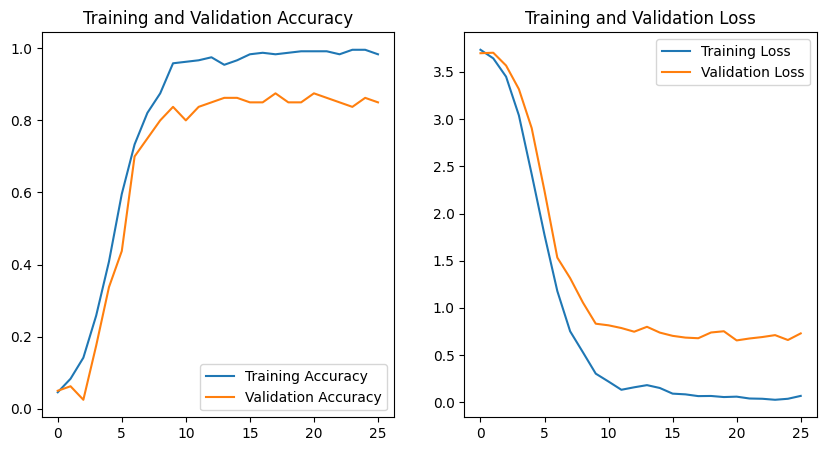

In [78]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

actual_train_epochs = len(history.history['accuracy'])

epochs_range = range(actual_train_epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [79]:
loss_func = SparseCategoricalCrossentropy()
classifier = TensorFlowV2Classifier(clip_values=(0, 1), model=model, nb_classes=40, input_shape=(64, 64, 1), loss_object=loss_func)
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.1)
X_test_adv = attack_fgsm.generate(x=X_test)

In [80]:
def l0_norm(real, adversarial):
    return np.sum(real != adversarial)

def l2_norm(real, adversarial):
    return np.linalg.norm(real - adversarial)

def linf_norm(real, adversarial):
    return np.max(np.abs(real - adversarial))

In [81]:
l0_dists = []
l2_dists = []
linf_dists = []

for real_img, adv_img in zip(X_test, X_test_adv):
    l0_dists.append(l0_norm(real_img, adv_img))
    l2_dists.append(l2_norm(real_img, adv_img))
    linf_dists.append(linf_norm(real_img, adv_img))

avg_l0 = np.mean(l0_dists)
avg_l2 = np.mean(l2_dists)
avg_linf = np.mean(linf_dists)

print(f"Average L0 Distortion: {avg_l0}")
print(f"Average L2 Distortion: {avg_l2}")
print(f"Average L∞ Distortion: {avg_linf}")

Average L0 Distortion: 4095.9875
Average L2 Distortion: 6.193068330753851
Average L∞ Distortion: 0.10000001516120105


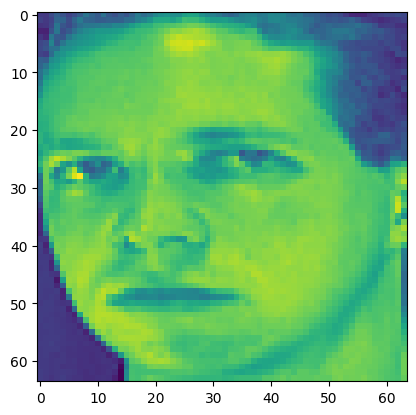

In [82]:
plt.imshow(X_test[0].squeeze())

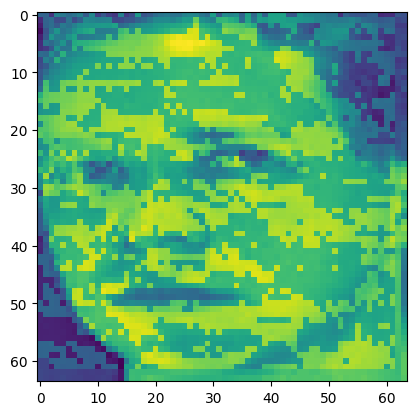

In [83]:
plt.imshow(X_test_adv[0].squeeze())

In [84]:
score_clean = model.evaluate(x=X_test, y=y_test)
score_adv = model.evaluate(x=X_test_adv, y=y_test)

print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs adversarial set test loss: {score_adv[0]:.2f}")

print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs adversarial test set accuracy: {score_adv[1]:.2f}")

3/3 [==============================] - 0s 49ms/step - loss: 11.1847 - accuracy: 0.0875
Clean test set loss: 0.46 vs adversarial set test loss: 11.18
Clean test set accuracy: 0.81 vs adversarial test set accuracy: 0.09


1/1 [==============================] - 0s 27ms/step


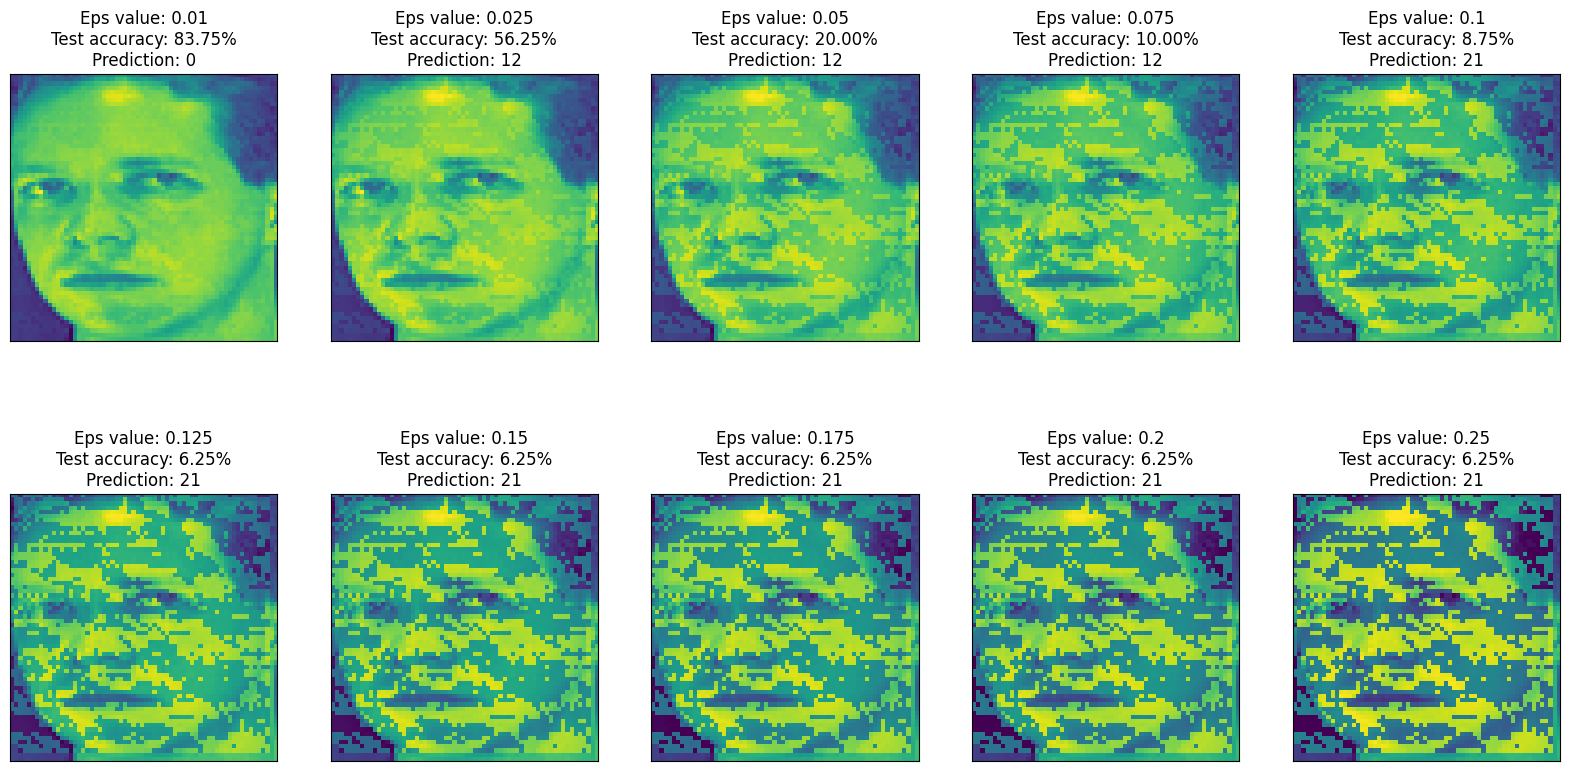

In [85]:
nrows, ncols = 2, 5

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(20, 10)
    )

eps_to_try = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25]

counter = 0

for i in range(nrows):
    for j in range(ncols):

        attack_fgsm = FastGradientMethod(
            estimator=classifier,
            eps=eps_to_try[counter]
            )

        test_images_adv = attack_fgsm.generate(x=X_test)

        axes[i, j].imshow(X=test_images_adv[0].squeeze())

        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        test_score = classifier._model.evaluate(
            x=test_images_adv,
            y=y_test
            )[1]

        prediction = np.argmax(model.predict(
            x=np.expand_dims(a=test_images_adv[0],
            axis=0)
            ))

        axes[i, j].set_title(
            label=f"Eps value: {eps_to_try[counter]}\n"
            f"Test accuracy: {test_score * 100:.2f}%\n"
            f"Prediction: {prediction}"
            )

        counter += 1

plt.show()

# Now let's improve

```
# This is formatted as code
```



In [86]:
#!pip install tensorflow

In [87]:
import warnings
warnings.filterwarnings('ignore')
from keras.datasets import mnist
from keras.models import load_model
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
import numpy as np

from art import config
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import ProjectedGradientDescent
from art.utils import get_file

In [88]:
X, y = load_dataset('data/')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train = X_train.reshape((-1, 64, 64, 1))
X_val = X_val.reshape((-1, 64, 64, 1))
X_test = X_test.reshape((-1, 64, 64, 1))

In [89]:
def generate_adversarial_examples(attack, X_train, y_train, X_val, y_val, X_test):
    X_train_adv = attack.generate(x=X_train)
    X_val_adv = attack.generate(x=X_val)

    # combine original and adversarial examples for training and validation
    X_train_mixed = np.concatenate((X_train, X_train_adv), axis=0)
    y_train_mixed = np.concatenate((y_train, y_train), axis=0)

    X_val_mixed = np.concatenate((X_val, X_val_adv), axis=0)
    y_val_mixed = np.concatenate((y_val, y_val), axis=0)

    X_test_adv = attack.generate(x=X_test)

    return X_train_mixed, y_train_mixed, X_val_mixed, y_val_mixed, X_test_adv

# fgms

In [90]:
loss_func = SparseCategoricalCrossentropy()
classifier = TensorFlowV2Classifier(clip_values=(0, 1), model=model, nb_classes=40, input_shape=(64, 64, 1), loss_object=loss_func)
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.01)
X_train_mixed_fgms, y_train_mixed_fgms, X_val_mixed_fgms, y_val_mixed_fgms, X_test_adv_fgms = generate_adversarial_examples(attack_fgsm, X_train, y_train, X_val, y_val, X_test)

In [91]:
new_model = build_model((64, 64, 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history_new_model = new_model.fit(
    X_train_mixed_fgms, y_train_mixed_fgms,
    epochs=50,
    batch_size=16,
    validation_data=(X_val_mixed_fgms, y_val_mixed_fgms),
    callbacks=[early_stopping]
)

Epoch 1/50
30/30 [==============================] - 4s 109ms/step - loss: 3.6828 - accuracy: 0.0437 - val_loss: 3.7548 - val_accuracy: 0.0000e+00
Epoch 2/50
30/30 [==============================] - 4s 139ms/step - loss: 3.3908 - accuracy: 0.1104 - val_loss: 3.4724 - val_accuracy: 0.0875
Epoch 3/50
30/30 [==============================] - 4s 136ms/step - loss: 2.4900 - accuracy: 0.3812 - val_loss: 2.5709 - val_accuracy: 0.3938
Epoch 4/50
30/30 [==============================] - 3s 97ms/step - loss: 1.5397 - accuracy: 0.6062 - val_loss: 1.5685 - val_accuracy: 0.6313
Epoch 5/50
30/30 [==============================] - 3s 104ms/step - loss: 0.7683 - accuracy: 0.7875 - val_loss: 1.0745 - val_accuracy: 0.7250
Epoch 6/50
30/30 [==============================] - 3s 101ms/step - loss: 0.4501 - accuracy: 0.8854 - val_loss: 0.7958 - val_accuracy: 0.8250
Epoch 7/50
30/30 [==============================] - 5s 168ms/step - loss: 0.3205 - accuracy: 0.9187 - val_loss: 0.8585 - val_accuracy: 0.8000
Epo

In [92]:
score_clean = new_model.evaluate(x=X_test, y=y_test)
score_adv = new_model.evaluate(x=X_test_adv_fgms, y=y_test)

print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs adversarial set test loss: {score_adv[0]:.2f}")

print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs adversarial test set accuracy: {score_adv[1]:.2f}")

3/3 [==============================] - 0s 37ms/step - loss: 0.5300 - accuracy: 0.8875
Clean test set loss: 0.50 vs adversarial set test loss: 0.53
Clean test set accuracy: 0.89 vs adversarial test set accuracy: 0.89


# IFGMS

In [93]:
loss_func = SparseCategoricalCrossentropy()
classifier = TensorFlowV2Classifier(clip_values=(0, 1), model=model, nb_classes=40, input_shape=(64, 64, 1), loss_object=loss_func)
attack_ifgsm = BasicIterativeMethod(estimator=classifier, eps=0.01, eps_step=0.01, max_iter=10)
X_train_mixed_ifgsm, y_train_mixed_ifgsm, X_val_mixed_ifgsm, y_val_mixed_ifgsm, X_test_adv_ifgsm = generate_adversarial_examples(attack_ifgsm, X_train, y_train, X_val, y_val, X_test)

PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

In [94]:
new_model_ifgms = build_model((64, 64, 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history_new_model_ifgms = new_model_ifgms.fit(
    X_train_mixed_ifgms, y_train_mixed_ifgms,
    epochs=50,
    batch_size=16,
    validation_data=(X_val_mixed_ifgms, y_val_mixed_ifgms),
    callbacks=[early_stopping]
)

Epoch 1/50
30/30 [==============================] - 6s 163ms/step - loss: 3.6736 - accuracy: 0.0604 - val_loss: 3.7416 - val_accuracy: 0.0125
Epoch 2/50
30/30 [==============================] - 3s 95ms/step - loss: 3.2877 - accuracy: 0.1583 - val_loss: 3.4681 - val_accuracy: 0.0375
Epoch 3/50
30/30 [==============================] - 3s 98ms/step - loss: 2.2908 - accuracy: 0.4167 - val_loss: 2.6114 - val_accuracy: 0.3000
Epoch 4/50
30/30 [==============================] - 3s 102ms/step - loss: 1.3424 - accuracy: 0.6833 - val_loss: 1.6371 - val_accuracy: 0.5750
Epoch 5/50
30/30 [==============================] - 4s 133ms/step - loss: 0.6902 - accuracy: 0.8250 - val_loss: 1.1212 - val_accuracy: 0.7312
Epoch 6/50
30/30 [==============================] - 4s 129ms/step - loss: 0.4078 - accuracy: 0.8938 - val_loss: 0.8341 - val_accuracy: 0.8125
Epoch 7/50
30/30 [==============================] - 3s 104ms/step - loss: 0.2939 - accuracy: 0.9292 - val_loss: 0.7584 - val_accuracy: 0.8438
Epoch 8/

In [95]:
score_clean = new_model_ifgms.evaluate(x=X_test, y=y_test)
score_adv = new_model_ifgms.evaluate(x=X_test_adv_ifgms, y=y_test)

print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs adversarial set test loss: {score_adv[0]:.2f}")

print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs adversarial test set accuracy: {score_adv[1]:.2f}")

3/3 [==============================] - 0s 30ms/step - loss: 0.4807 - accuracy: 0.8375
Clean test set loss: 0.36 vs adversarial set test loss: 0.48
Clean test set accuracy: 0.90 vs adversarial test set accuracy: 0.84


# CW

In [65]:
loss_func = SparseCategoricalCrossentropy()
classifier = TensorFlowV2Classifier(clip_values=(0, 1), model=model, nb_classes=40, input_shape=(64, 64, 1), loss_object=loss_func)
attack_cw = CarliniL2Method(classifier=classifier, confidence=0.1, batch_size=16, learning_rate=0.01, max_iter=10)
X_train_mixed_cw, y_train_mixed_cw, X_val_mixed_cw, y_val_mixed_cw, X_test_adv_cw = generate_adversarial_examples(attack_cw, X_train, y_train, X_val, y_val, X_test)

C&W L_2:   0%|          | 0/15 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/5 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/5 [00:00<?, ?it/s]

In [66]:
new_model_cw = build_model((64, 64, 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history_new_model_cw = new_model_cw.fit(
    X_train_mixed_cw, y_train_mixed_cw,
    epochs=50,
    batch_size=16,
    validation_data=(X_val_mixed_cw, y_val_mixed_cw),
    callbacks=[early_stopping]
)

Epoch 1/50
30/30 [==============================] - 4s 106ms/step - loss: 3.6702 - accuracy: 0.0521 - val_loss: 3.6837 - val_accuracy: 0.0625
Epoch 2/50
30/30 [==============================] - 3s 87ms/step - loss: 3.1943 - accuracy: 0.2375 - val_loss: 3.1835 - val_accuracy: 0.2750
Epoch 3/50
30/30 [==============================] - 4s 122ms/step - loss: 2.0113 - accuracy: 0.5042 - val_loss: 2.1340 - val_accuracy: 0.4812
Epoch 4/50
30/30 [==============================] - 4s 147ms/step - loss: 0.9953 - accuracy: 0.7437 - val_loss: 1.3520 - val_accuracy: 0.6313
Epoch 5/50
30/30 [==============================] - 3s 89ms/step - loss: 0.5240 - accuracy: 0.8854 - val_loss: 0.8475 - val_accuracy: 0.7688
Epoch 6/50
30/30 [==============================] - 3s 102ms/step - loss: 0.2838 - accuracy: 0.9104 - val_loss: 0.6669 - val_accuracy: 0.8375
Epoch 7/50
30/30 [==============================] - 3s 88ms/step - loss: 0.1857 - accuracy: 0.9583 - val_loss: 0.5959 - val_accuracy: 0.8188
Epoch 8/5

In [67]:
score_clean = new_model_cw.evaluate(x=X_test, y=y_test)
score_adv = new_model_cw.evaluate(x=X_test_adv_cw, y=y_test)

print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs adversarial set test loss: {score_adv[0]:.2f}")

print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs adversarial test set accuracy: {score_adv[1]:.2f}")

3/3 [==============================] - 0s 54ms/step - loss: 0.4043 - accuracy: 0.8875
Clean test set loss: 0.32 vs adversarial set test loss: 0.40
Clean test set accuracy: 0.89 vs adversarial test set accuracy: 0.89


# Universal perturbation

In [68]:
loss_func = SparseCategoricalCrossentropy()
classifier = TensorFlowV2Classifier(clip_values=(0, 1), model=model, nb_classes=40, input_shape=(64, 64, 1), loss_object=loss_func)
attack_up = UniversalPerturbation(classifier=classifier, attacker='fgsm', eps=0.01)
X_train_mixed_up, y_train_mixed_up, X_val_mixed_up, y_val_mixed_up, X_test_adv_up = generate_adversarial_examples(attack_up, X_train, y_train, X_val, y_val, X_test)

Universal perturbation:   0%|          | 0/20 [00:00<?, ?it/s]

Universal perturbation:   0%|          | 0/20 [00:00<?, ?it/s]

Universal perturbation:   0%|          | 0/20 [00:00<?, ?it/s]

In [69]:
new_model_up = build_model((64, 64, 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history_new_model_up = new_model_up.fit(
    X_train_mixed_up, y_train_mixed_up,
    epochs=50,
    batch_size=16,
    validation_data=(X_val_mixed_up, y_val_mixed_up),
    callbacks=[early_stopping]
)

Epoch 1/50
30/30 [==============================] - 4s 101ms/step - loss: 3.6989 - accuracy: 0.0396 - val_loss: 3.7284 - val_accuracy: 0.0000e+00
Epoch 2/50
30/30 [==============================] - 3s 100ms/step - loss: 3.4558 - accuracy: 0.1333 - val_loss: 3.5360 - val_accuracy: 0.1000
Epoch 3/50
30/30 [==============================] - 3s 98ms/step - loss: 2.7121 - accuracy: 0.3083 - val_loss: 3.0309 - val_accuracy: 0.2750
Epoch 4/50
30/30 [==============================] - 5s 157ms/step - loss: 1.7943 - accuracy: 0.5250 - val_loss: 2.0838 - val_accuracy: 0.5437
Epoch 5/50
30/30 [==============================] - 3s 96ms/step - loss: 1.0787 - accuracy: 0.7229 - val_loss: 1.4243 - val_accuracy: 0.6812
Epoch 6/50
30/30 [==============================] - 3s 95ms/step - loss: 0.7174 - accuracy: 0.8125 - val_loss: 1.0652 - val_accuracy: 0.7437
Epoch 7/50
30/30 [==============================] - 3s 89ms/step - loss: 0.4958 - accuracy: 0.8604 - val_loss: 0.9083 - val_accuracy: 0.8062
Epoch 

In [70]:
score_clean = new_model_up.evaluate(x=X_test, y=y_test)
score_adv = new_model_up.evaluate(x=X_test_adv_up, y=y_test)

print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs adversarial set test loss: {score_adv[0]:.2f}")

print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs adversarial test set accuracy: {score_adv[1]:.2f}")

3/3 [==============================] - 0s 52ms/step - loss: 0.4320 - accuracy: 0.8875
Clean test set loss: 0.43 vs adversarial set test loss: 0.43
Clean test set accuracy: 0.89 vs adversarial test set accuracy: 0.89
